In [1]:
import requests
from bs4 import BeautifulSoup
import pandas as pd

# Step 1: URL
url = "https://www.basketball-reference.com/leagues/NBA_2024_per_game.html"

# Step 2: fetch raw HTML content
headers = {"User-Agent": "Mozilla/5.0"}
response = requests.get(url, headers=headers)

# Step 3: parse HTML content
soup = BeautifulSoup(response.text, "html.parser")

# Step 4: find stats
table = soup.find("table", {"id": "per_game_stats"})

# Step 5: extract headers (column names)
headers = [th.get_text() for th in table.find("thead").find_all("th")][1:]

# Step 6: extract rows (player's data)
data = []
for row in table.find("tbody").find_all("tr", class_=lambda x: x != "thead"):
    cells = row.find_all("td")
    if not cells:
        continue  # empty rows
    data.append([cell.get_text() for cell in cells])

# Step 7: create a dataframe
df = pd.DataFrame(data, columns=headers)

# Step 8: clean the data (drop rows with missing values/columns not needed)
df.dropna(inplace=True)
df.drop(columns=['G','GS','ORB','DRB','Awards'], inplace=True)

# Step 9: save data to a CSV file
df.to_csv("nbastats2024.csv", index=False)

# Step 10: display to verify
print(df.head(20))

# filter for multiple players
# players = df[df['Player'].isin(['Jalen Williams', 'Brandin Podziemski'])]
# print(players)

                     Player Age Team Pos    MP    FG   FGA   FG%   3P   3PA  \
0               Joel Embiid  29  PHI   C  33.6  11.5  21.8  .529  1.4   3.6   
1             Luka DonÄiÄ  24  DAL  PG  37.5  11.5  23.6  .487  4.1  10.6   
2     Giannis Antetokounmpo  29  MIL  PF  35.2  11.5  18.8  .611  0.5   1.7   
3   Shai Gilgeous-Alexander  25  OKC  PG  34.0  10.6  19.8  .535  1.3   3.6   
4             Jalen Brunson  27  NYK  PG  35.4  10.3  21.4  .479  2.7   6.8   
5              Devin Booker  27  PHO  PG  36.0   9.4  19.2  .492  2.2   6.1   
6              Kevin Durant  35  PHO  PF  37.2  10.0  19.1  .523  2.2   5.4   
7              Jayson Tatum  25  BOS  PF  35.7   9.1  19.3  .471  3.1   8.2   
8              De'Aaron Fox  26  SAC  PG  35.9   9.7  20.9  .465  2.9   7.8   
9          Donovan Mitchell  27  CLE  SG  35.3   9.1  19.8  .462  3.3   9.0   
10            Stephen Curry  35  GSW  PG  32.7   8.8  19.5  .450  4.8  11.8   
11            Nikola JokiÄ  28  DEN   C  34.6  10.4

**Apriori Algorithm - Manual Function**

In [2]:
import pandas as pd
from itertools import combinations

df = pd.read_csv("nbastats2024.csv")

#convert
df["PTS"] = pd.to_numeric(df["PTS"], errors="coerce")
df["3P"] = pd.to_numeric(df["3P"], errors="coerce")
df["AST"] = pd.to_numeric(df["AST"], errors="coerce")
df["TRB"] = pd.to_numeric(df["TRB"], errors="coerce")

# thresholds for classification
df["High Scorer"] = df["PTS"] > 15
df["Three-Point Shooter"] = df["3P"] > 2.0
df["Playmaker"] = df["AST"] > 5
df["Strong Rebounder"] = df["TRB"] > 6

df_encoded = df[["High Scorer", "Three-Point Shooter", "Playmaker", "Strong Rebounder"]].astype(bool)

min_support = 0.02

num_players = len(df_encoded)
item_support = df_encoded.mean()

frequent_items = {frozenset([item]): support for item, support in item_support.items() if support >= min_support}

def generate_combinations(itemsets, k):
    return [i1.union(i2) for i1 in itemsets for i2 in itemsets if len(i1.union(i2)) == k]

frequent_itemsets = []
current_itemsets = frequent_items.copy()

k = 2
while current_itemsets:
    frequent_itemsets.append(current_itemsets)

    candidate_itemsets = generate_combinations(current_itemsets.keys(), k)

    itemset_counts = {itemset: df_encoded[list(itemset)].all(axis=1).mean() for itemset in candidate_itemsets}

    current_itemsets = {itemset: support for itemset, support in itemset_counts.items() if support >= min_support}

    k += 1

frequent_itemsets_dict = {k: v for d in frequent_itemsets for k, v in d.items()}

rules = []
min_confidence = 0.03

for itemset, support in frequent_itemsets_dict.items():
    if len(itemset) < 2:
        continue

    for i in range(1, len(itemset)):
        for antecedent in combinations(itemset, i):
            antecedent = frozenset(antecedent)
            consequent = itemset - antecedent

            antecedent_support = frequent_itemsets_dict.get(antecedent, 0)
            confidence = support / antecedent_support if antecedent_support > 0 else 0

            consequent_support = frequent_itemsets_dict.get(consequent, 0)
            lift = confidence / consequent_support if consequent_support > 0 else 0

            if confidence >= min_confidence:
                rules.append({
                    "Antecedents": antecedent,
                    "Consequents": consequent,
                    "Support": support,
                    "Confidence": confidence,
                    "Lift": lift
                })

rules_df = pd.DataFrame(rules)

def count_players(antecedents, consequents):
    antecedent_cols = list(antecedents)
    consequent_cols = list(consequents)
    mask = df_encoded[antecedent_cols].all(axis=1) & df_encoded[consequent_cols].all(axis=1)
    return mask.sum()

rules_df["Player Count"] = rules_df.apply(lambda row: count_players(row["Antecedents"], row["Consequents"]), axis=1)
print(rules_df[['Antecedents', 'Consequents', 'Support', 'Confidence', 'Lift', 'Player Count']])


                           Antecedents                         Consequents  \
0                        (High Scorer)               (Three-Point Shooter)   
1                (Three-Point Shooter)                       (High Scorer)   
2                        (High Scorer)                         (Playmaker)   
3                          (Playmaker)                       (High Scorer)   
4                        (High Scorer)                  (Strong Rebounder)   
5                   (Strong Rebounder)                       (High Scorer)   
6                          (Playmaker)               (Three-Point Shooter)   
7                (Three-Point Shooter)                         (Playmaker)   
8                        (High Scorer)    (Playmaker, Three-Point Shooter)   
9                          (Playmaker)  (High Scorer, Three-Point Shooter)   
10               (Three-Point Shooter)            (High Scorer, Playmaker)   
11            (High Scorer, Playmaker)               (Three-Poin

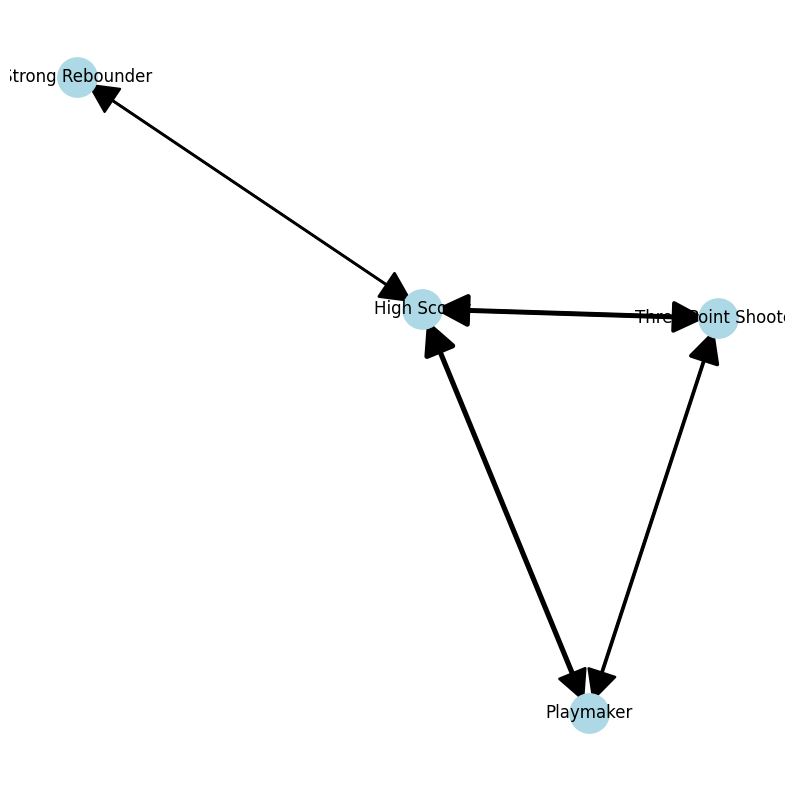

In [3]:
import networkx as nx
import matplotlib.pyplot as plt

directed_graph = nx.DiGraph()

# displaying network graph between two nodes
edges = [
    ('High Scorer', 'Three-Point Shooter', 0.56),
    ('Three-Point Shooter', 'High Scorer', 0.71),
    ('High Scorer', 'Playmaker', 0.39),
    ('Playmaker', 'High Scorer', 0.74),
    ('Strong Rebounder', 'High Scorer', 0.42),
    ('High Scorer', 'Strong Rebounder', 0.32),
    ('Playmaker', 'Three-Point Shooter', 0.54),
    ('Three-Point Shooter', 'Playmaker', 0.36),
]

for s, t, weight in edges:
    directed_graph.add_edge(s, t, weight=weight)

plt.figure(figsize=(10, 10))
pos = nx.spring_layout(directed_graph, seed=42)
nx.draw_networkx_nodes(directed_graph, pos, node_size=800, node_color='lightblue')

weights = [directed_graph[u][v]['weight'] * 5 for u, v, _ in edges]
nx.draw_networkx_edges(directed_graph, pos, edgelist=edges, width=weights, arrowstyle='-|>', arrowsize=50)

nx.draw_networkx_labels(directed_graph, pos, font_size=12, font_family='sans-serif')
plt.axis('off')
plt.show()

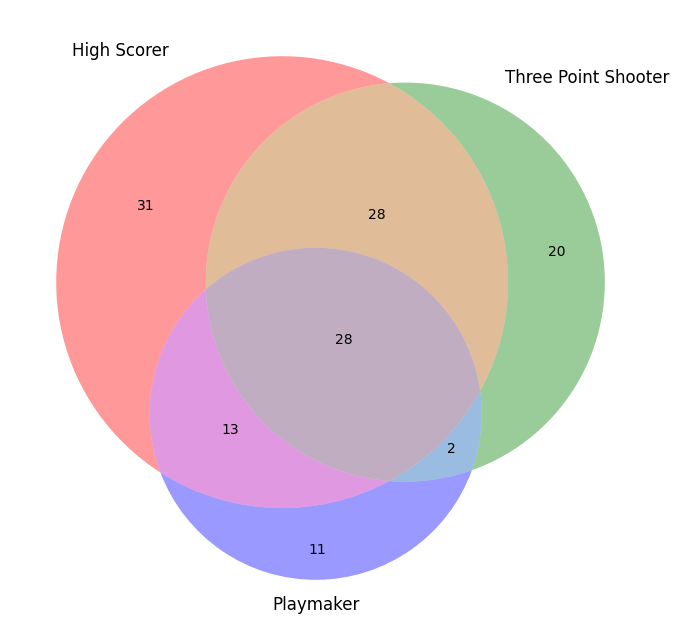

In [4]:
from matplotlib_venn import venn3
import matplotlib.pyplot as plt

# Assuming 'df' contains player data with the defined conditions
high_scorers = set(df[df['High Scorer']]['Player'])
three_point_shooters = set(df[df['Three-Point Shooter']]['Player'])
playmakers = set(df[df['Playmaker']]['Player'])

# Create the Venn diagram
plt.figure(figsize=(10, 8))
venn3(
    [high_scorers, three_point_shooters, playmakers],
    set_labels=('High Scorer', 'Three Point Shooter', 'Playmaker')
)

plt.show()


**FP Growth Algorithm**

In [5]:
df.head()

,Player,Age,Team,Pos,MP,FG,FGA,FG%,3P,3PA,...,AST,STL,BLK,TOV,PF,PTS,High Scorer,Three-Point Shooter,Playmaker,Strong Rebounder
0,Joel Embiid,29.0,PHI,C,33.6,11.5,21.8,0.529,1.4,3.6,...,5.6,1.2,1.7,3.8,2.9,34.7,True,False,True,True
1,Luka DonÄiÄ,24.0,DAL,PG,37.5,11.5,23.6,0.487,4.1,10.6,...,9.8,1.4,0.5,4.0,2.1,33.9,True,True,True,True
2,Giannis Antetokounmpo,29.0,MIL,PF,35.2,11.5,18.8,0.611,0.5,1.7,...,6.5,1.2,1.1,3.4,2.9,30.4,True,False,True,True
3,Shai Gilgeous-Alexander,25.0,OKC,PG,34.0,10.6,19.8,0.535,1.3,3.6,...,6.2,2.0,0.9,2.2,2.5,30.1,True,False,True,False
4,Jalen Brunson,27.0,NYK,PG,35.4,10.3,21.4,0.479,2.7,6.8,...,6.7,0.9,0.2,2.4,1.9,28.7,True,True,True,False


In [6]:
df.shape

(736, 29)

In [7]:
from mlxtend.frequent_patterns import fpgrowth, association_rules

fp_frequent_itemsets = fpgrowth(df_encoded, min_support=0.02, use_colnames=True)
fp_frequent_itemsets.head()

,support,itemsets
0,0.146739,(High Scorer)
1,0.112772,(Strong Rebounder)
2,0.077446,(Playmaker)
3,0.115489,(Three-Point Shooter)
4,0.047554,"(High Scorer, Strong Rebounder)"


In [8]:
fp_rules = association_rules(fp_frequent_itemsets, metric="confidence", min_threshold=0.40)
fp_rules['Player Count'] = fp_rules['support'] * len(df_encoded)
results = fp_rules[['antecedents', 'consequents', 'support', 'confidence', 'lift', 'Player Count']]
results.loc[:, 'support'] = results['support'].round(3)
results.loc[:, 'confidence'] = results['confidence'].round(3)
results.loc[:, 'lift'] = results['lift'].round(3)

In [9]:
from IPython.display import display
display(results)

,antecedents,consequents,support,confidence,lift,Player Count
0,(Strong Rebounder),(High Scorer),0.048,0.422,2.874,35.0
1,(Playmaker),(High Scorer),0.057,0.737,5.021,42.0
2,(Playmaker),(Three-Point Shooter),0.042,0.544,4.709,31.0
3,"(High Scorer, Playmaker)",(Three-Point Shooter),0.039,0.690,5.979,29.0
4,"(High Scorer, Three-Point Shooter)",(Playmaker),0.039,0.483,6.241,29.0
5,"(Playmaker, Three-Point Shooter)",(High Scorer),0.039,0.935,6.375,29.0
6,(Playmaker),"(High Scorer, Three-Point Shooter)",0.039,0.509,6.241,29.0
7,(High Scorer),(Three-Point Shooter),0.082,0.556,4.810,60.0
8,(Three-Point Shooter),(High Scorer),0.082,0.706,4.810,60.0


In [10]:
player_filter = df[
    (df['Playmaker'] == True) &
    (df['Three-Point Shooter'] == True) &
    (df['High Scorer'] == True)
]

player_filter[['Player', 'Team', 'Pos', 'PTS', '3P%', 'AST', 'TRB']]

,Player,Team,Pos,PTS,3P%,AST,TRB
1,Luka DonÄiÄ,DAL,PG,33.9,0.382,9.8,9.2
4,Jalen Brunson,NYK,PG,28.7,0.401,6.7,3.6
5,Devin Booker,PHO,PG,27.1,0.364,6.9,4.5
8,De'Aaron Fox,SAC,PG,26.6,0.369,5.6,4.6
9,Donovan Mitchell,CLE,SG,26.6,0.368,6.1,5.1
10,Stephen Curry,GSW,PG,26.4,0.408,5.1,4.5
12,Anthony Edwards,MIN,SG,25.9,0.357,5.1,5.4
13,Tyrese Maxey,PHI,PG,25.9,0.373,6.2,3.7
14,LeBron James,LAL,PF,25.7,0.410,8.3,7.3
15,Trae Young,ATL,PG,25.7,0.373,10.8,2.8


<b> Closed Association Rule Mining (CHARM-Approach) </b>

As we can see, FP-Growth outputted many rules, but we want the most crucial and non-redundant ones. We learned about CHARM through this [scholarly article]( https://link.springer.com/referenceworkentry/10.1007/978-0-387-39940-9_66#:~:text=An%20(frequent)%20itemset%20is%20called,as%20sup(A%20%E2%87%92%20B)).

In [11]:
def closed_itemset(fp_frequent_itemsets):
  fp_frequent_itemsets['length'] = fp_frequent_itemsets['itemsets'].apply(lambda x: len(x))
  fp_frequent_itemsets.sort_values(by='length', ascending=False)

  closed_itemsets = []

  for i, row in fp_frequent_itemsets.iterrows():
    itemset = row['itemsets']
    is_subset = any(set(itemset).issubset(set(closed)) for closed in closed_itemsets)

    if not is_subset:
      closed_itemsets.append(itemset)

  return closed_itemsets

In [12]:
closed_itemsets = closed_itemset(fp_frequent_itemsets)
closed_itemsets_df = pd.DataFrame({'Closed Itemsets': closed_itemsets})
closed_itemsets_df

,Closed Itemsets
0,(High Scorer)
1,(Strong Rebounder)
2,(Playmaker)
3,(Three-Point Shooter)
4,"(High Scorer, Strong Rebounder)"
5,"(High Scorer, Playmaker)"
6,"(Playmaker, Three-Point Shooter)"
7,"(High Scorer, Playmaker, Three-Point Shooter)"


<b> Content-Based Filtering Recommendation System </b>

Now that we know which traits are important, we use Cosine Similarity to find players who are statistically similar.

In [13]:
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import StandardScaler

df = pd.read_csv("nbastats2024.csv")

df.dropna(inplace=True)

features = df[["PTS", "3P", "AST", "TRB"]]

scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

cosine_sim = cosine_similarity(features_scaled)

cosine_sim_df = pd.DataFrame(cosine_sim, index=df['Player'], columns=df['Player'])

def recommend_players(player_name, top_n=20):
    if player_name not in cosine_sim_df.index:
        return f"{player_name} not found in the data."

    similar_scores = cosine_sim_df[player_name]

    similar_players = similar_scores.sort_values(ascending=False)[1:top_n+1]

    return similar_players

# recommend similar players to "NBA Player"
similar_players = recommend_players("Stephen Curry", top_n=20)
print(similar_players)

Player
CJ McCollum           0.997208
Herbert Jones         0.996115
OG Anunoby            0.991355
Bogdan BogdanoviÄ    0.989549
Mikal Bridges         0.985731
Paul George           0.980678
Grayson Allen         0.979539
Tyler Herro           0.978702
Jalen Suggs           0.978421
Anfernee Simons       0.977283
Desmond Bane          0.973279
De'Anthony Melton     0.970385
Bojan BogdanoviÄ     0.966640
Brandon Miller        0.965441
Devin Vassell         0.965112
Cameron Johnson       0.960826
Donte DiVincenzo      0.959157
Jalen Green           0.956773
Buddy Hield           0.956127
Klay Thompson         0.953825
Name: Stephen Curry, dtype: float64
